<a href="https://colab.research.google.com/github/rodricanaglia/CursoUTN/blob/main/data_uruguay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [14]:
!pip install scikit-optimize
!pip install -U scikeras
!pip install tensorflow
!pip install keras

In [28]:
import logging
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics, linear_model
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split, ShuffleSplit, cross_validate, GridSearchCV, RandomizedSearchCV)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, normalize)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
from keras import callbacks
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import warnings


# Set the path (adjust according to your directory structure)
path = '/content/gdrive/My Drive/UTN/PhD/Proyecto_MACHINE_LEARNING_2018/Dataset_URU'
sys.path.append(path)

In [16]:
# Ruta de la carpeta base
carpeta_base = '/content/drive/MyDrive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/NN_RCV_reg/Resultados'  # Cambia esta ruta según donde quieras crear las carpetas

# Crear la carpeta 'NN_RCV_reg' y subcarpeta 'Resultados'
carpeta_resultados = os.path.join(carpeta_base, 'NN_RCV_reg', 'Resultados')
os.makedirs(carpeta_resultados, exist_ok=True)

In [17]:
# Rutas de las carpetas que quieres crear
folders_to_create = [
    '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/NN_RCV_reg/',
    '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/SVM_RCV_reg/',
    '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/RF_RCV_reg/'
]

# Crear las carpetas si no existen
for folder in folders_to_create:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [18]:
root_path = "/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Dataset_URU/"
xls=pd.ExcelFile(root_path+'BD_Sphygmocor_URU.xls')
df_uru = pd.read_excel(xls, 'Uru_database')


Exception ignored in: <function ExcelFile.__del__ at 0x7875434509d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/excel/_base.py", line 1779, in __del__
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/excel/_base.py", line 1767, in close
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/excel/_base.py", line 574, in close
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/common.py", line 125, in close
OSError: [Errno 107] Transport endpoint is not connected


In [19]:
carpeta_NN = '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/NN_RCV_reg/'
carpeta_SVM = '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/SVM_RCV_reg/'
carpeta_RF = '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/RF_RCV_reg/'

In [20]:
col_drop = ['Name','Framingham','AAI','Cholesterol','HDL','LDL','BMI','Diabetes','Tabacco','Sex','PWV']
categorical = []
target= 'SBP_A'
df_uru = df_uru.drop(col_drop,axis=1)
df_uru = df_uru.dropna()
df_uru.columns
#shape2 = df_uru.shape

Index(['Age', 'SBP_P', 'SBP_A', 'DBP_H', 'CIMT_R', 'CIMT_L'], dtype='object')

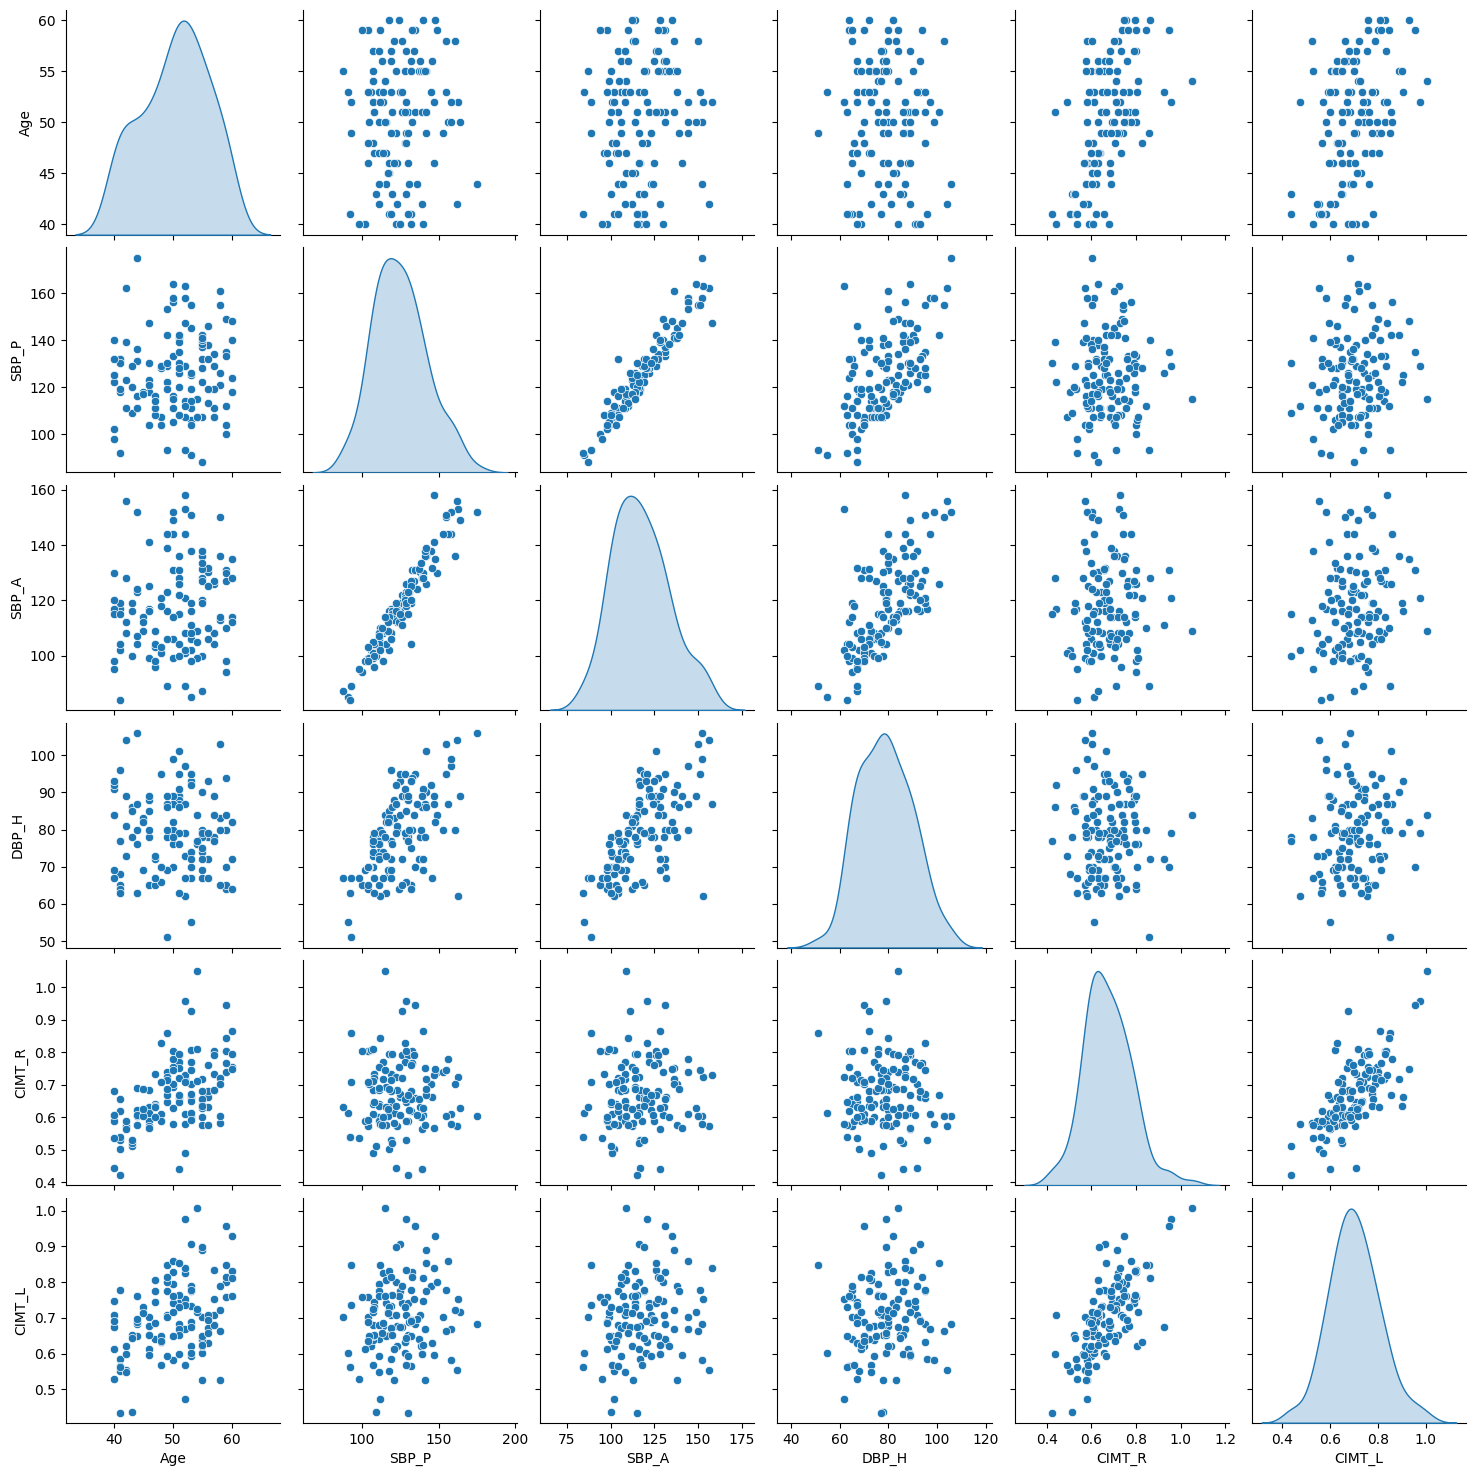

In [21]:
ft =['SBP_P','DBP_H']
sns.pairplot(df_uru,diag_kind="kde")
plt.show()

<ipython-input-22-79cf4cc16d1a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_uru['SBP_A'],norm_hist=False)


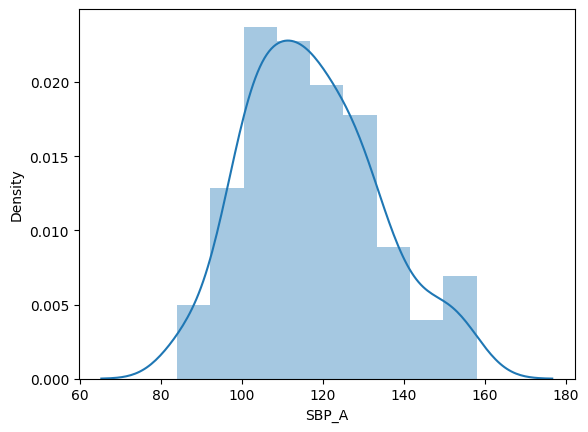

In [22]:
ft =['SBP_A']
sns.distplot(df_uru['SBP_A'],norm_hist=False)
plt.show()

In [48]:
def data(df_uru, categorical, target, t_size, r_s):
    df = df_uru.copy()
    y = df.pop(target).values
    x = df

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=t_size, random_state=r_s
    )

    x_train_no_norm = x_train[categorical].copy()
    x_train = x_train.drop(columns=categorical)
    x_test_no_norm = x_test[categorical].copy()
    x_test = x_test.drop(columns=categorical)

    # Normalize
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)

    # Concatenate
    x_train_norm_full = np.concatenate([x_train_norm, x_train_no_norm], axis=1)
    x_test_norm_full = np.concatenate([x_test_norm, x_test_no_norm], axis=1)

    return x_train_norm_full, x_test_norm_full, y_train, y_test

def func_mae_RF_regr(
        x, y, t_size, kfold, grid,randomsearch,num_iter):

    # Config de Clasificador
    rfr = RandomForestRegressor()
    # Config del Cross-Validdation
    cv_cfg = ShuffleSplit(n_splits=kfold, test_size=t_size)

    # Parametros
    score = 'neg_mean_absolute_error'
    if randomsearch==False:
        reg = GridSearchCV(rfr, grid, cv=cv_cfg, scoring=score, n_jobs=-1)
    else:
        reg = RandomizedSearchCV(estimator = rfr, param_distributions = grid, n_iter = num_iter, cv = cv_cfg, n_jobs = -1)# Fit the random search model

    gs = reg.fit(x, y)

    # Print Resultados
    print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
    means_test = gs.cv_results_['mean_test_score']
    stds_test = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']
    # Grid Search Print
    for meants, stdevts, param in zip(means_test, stds_test, params):
        print("Test:%f (%f) with: %r" % (meants, stdevts, param))
    cv_bs = gs.best_score_
    print(cv_bs)
    cv_result = gs.cv_results_
    cv_bp = gs.best_params_
    cv_bi = gs.best_index_
    resultado = {
            'cv_result': cv_result, 'best_params': cv_bp,
            'best_index': cv_bi, 'best_score': cv_bs}
    return(resultado)


def func_RF_RCV_reg(df_uru, categorical,target, t_size,r_s, kfold, grid,randomsearch,num_iter):

    x_train_norm_full, x_test_norm_full, y_train, y_test = data(df_uru,categorical,target,t_size,r_s)
    y_train = y_train
    y_test = y_test

    resultado_RF_reg = func_mae_RF_regr(
        x_train_norm_full, y_train,
        t_size, kfold,
        grid,randomsearch,num_iter)

    df = pd.DataFrame(data=resultado_RF_reg)
    carpeta = '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/RF_RCV_reg/'
    base_name = '['+str(target)+']'
    fname_resultado = base_name+'_resultadoGS.pkl'
    df.to_pickle(carpeta+fname_resultado)
    return(resultado_RF_reg['best_params'])

# Smooth
def smooth_curve(points, factor):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def bland_altman_plot(data1, data2,modelo,marca,clr='b',ax=None):
    sd_limit = 1.96
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    if ax is None:
        ax = plt.gca()
    ax.scatter(mean, diff,color=clr,alpha=0.5,label=modelo,marker=marca)
    ax.axhline(md,           color=clr,linewidth=2)
    ax.axhline(md + sd_limit*sd, color=clr, linestyle='--')
    ax.axhline(md - sd_limit*sd, color=clr, linestyle='--')

    half_ylim = (1.5 * sd_limit) * sd
    ax.set_ylim(md - half_ylim,
                    md + half_ylim)

    # Annotate mean line with mean difference.
    ax.annotate('Mean: {}'.format(np.round(md, 2)),
                xy=(0.99, 0.55),
                horizontalalignment='right',
                verticalalignment='center',
                fontsize=18,
                xycoords='axes fraction')
    limit_of_agreement = sd_limit * sd
    lower = md - limit_of_agreement
    upper = md + limit_of_agreement
    print(f'-SD , Media, +SD :\r\n[ {np.round(lower, 2)}\r\n{np.round(md, 2)}\r\n{np.round(upper, 2)}')
    for j, lim in enumerate([lower, upper]):
        ax.annotate(r"-$\sigma$ {}: {}".format(sd_limit, np.round(lower, 2)),
                    xy=(0.99, 0.1),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=18,
                    xycoords='axes fraction')
        ax.annotate(r"+$\sigma$ {}: {}".format(sd_limit, np.round(upper, 2)),
                    xy=(0.99, 0.85),
                    horizontalalignment='right',
                    fontsize=18,
                    xycoords='axes fraction')

def result_plot(y_test,y_pred,error_pred,mae,mse,target,lim_pred,lim_error,color='b',marca='s',modelo='NN'):

    regr = linear_model.LinearRegression()
    regr.fit(y_test.reshape(-1,1), y_pred.reshape(-1,1))

    lin_y_pred = regr.predict(y_pred.reshape(-1,1))

    lin_pred = regr.predict(y_pred.reshape(-1,1))
    r2 = np.round(r2_score(y_pred.reshape(-1,1), lin_y_pred.reshape(-1,1)),2)

    print(f"R2_{modelo}, MSE_{modelo}, MAE_{modelo} : ")
    print(f'{np.round(r2,2)}\r\n{np.round(mse,2)}\r\n{np.round(mae,2)}')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    lin_x_pred = np.arange(lim_pred[0],lim_pred[1],dtype=np.float)
    lin_y_pred = regr.predict(lin_x_pred.reshape(-1,1))

    f, (ax0, ax1,ax2) = plt.subplots(1, 3, figsize=(17, 5))
    ax0.scatter(y_test, y_pred,c=color,marker=marca,alpha=0.5,label=modelo)

    ax0.plot(lin_x_pred, lin_y_pred, color='k', linewidth=2)

    ax0.plot(y_pred, lin_pred, color='k', linewidth=1)
    ax0.set_xlabel(target+' True [mmHg]',fontsize=18)
    ax0.set_ylabel(target+' Estimated [mmHg]',fontsize=18)
    ax0.axis('equal')
    ax0.axis('equal')
    ax0.set_xlim(lim_pred)
    ax0.set_ylim(lim_pred)
    ax0.plot([-200, 200], [-200, 200], color='g')
    ax0.legend()
    ax0.text(0.65, 0.3, r"$\mathrm{R}^2=$"+str(r2), transform=ax0.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    ax0.text(0.65, 0.2, 'MSE='+str(np.round(mse,2)), transform=ax0.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    ax0.text(0.65, 0.1, 'MAE='+str(np.round(mae,2)), transform=ax0.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    ax0.set_title(target + ': True vs. Estimated',fontsize=24)
    bland_altman_plot(y_pred, y_test,modelo,marca,clr=color,ax=ax1)
    ax1.set_title('Bland-Altman',fontsize=24)
    ax1.legend()
    ax1.set_ylim(lim_error)
    ax1.set_xlabel('Mean [mmHg]',fontsize=18)
    ax1.set_ylabel('Difference [mmHg]',fontsize=18)
    ax2.hist(error_pred, alpha=0.5,color=color,label=modelo)
    ax2.set_xlabel("Errors",fontsize=18)
    ax2.set_ylabel("Counts",fontsize=18)
    ax2.set_xlim(lim_error)
    ax2.legend()
    ax2.set_title('Histogram of errors',fontsize=24)
    plt.savefig(modelo+"_results.pdf", dpi=300)
    plt.show()
    return ( f, (ax0, ax1,ax2) )

def build_model(input_size=9, neurons1=8, neurons2=8, neurons3=8, neurons4=8,
                activation_f='sigmoid', optimizer='rmsprop', l_rate=0.01,
                r_rate=0.02, drop=0.1, bias_initi=7.5):

    K.clear_session()

    # Initializers
    init_k = keras.initializers.glorot_uniform(seed=0)
    init_b = keras.initializers.Constant(bias_initi)

    # Building the model
    model = Sequential()

    # First layer
    model.add(Dense(neurons1, activation=activation_f, input_shape=(input_size,),
                    kernel_initializer=init_k, kernel_regularizer=l2(r_rate)))
    model.add(BatchNormalization())
    model.add(Dropout(drop))

    # Additional layers based on the number of neurons specified
    if neurons2 > 0:
        model.add(Dense(neurons2, activation=activation_f,
                        kernel_initializer=init_k, kernel_regularizer=l2(r_rate)))
        model.add(BatchNormalization())
        model.add(Dropout(drop))

    if neurons3 > 0:
        model.add(Dense(neurons3, activation=activation_f,
                        kernel_initializer=init_k, kernel_regularizer=l2(r_rate)))
        model.add(BatchNormalization())
        model.add(Dropout(drop))

    if neurons4 > 0:
        model.add(Dense(neurons4, activation=activation_f,
                        kernel_initializer=init_k, kernel_regularizer=l2(r_rate)))
        model.add(BatchNormalization())
        model.add(Dropout(drop))

    # Output layer
    model.add(Dense(1, activation=activation_f,
                    kernel_initializer=init_k, bias_initializer=init_b,
                    kernel_regularizer=l2(r_rate)))

    # Setting the optimizer
    if optimizer.lower() == 'adam':
        opt = keras.optimizers.Adam(learning_rate=l_rate)
    elif optimizer.lower() == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=l_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    # Compiling the model
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    return model

def func_mae_NN_regr_GS(
        x, y,
        vec_neurons1, vec_neurons2, vec_neurons3, vec_neurons4,
        vec_optimizer, vec_act_func, bias_initi, r_rate, vec_batch_size, vec_epochs, kfold, t_size,
        carpeta, fname_best_model):
    # fix random seed for reproducibility
    seed = 22
    i_size = np.shape(x)[1]
    print(f"Imput_size{i_size}")
    cv_cfg = ShuffleSplit(n_splits=kfold, test_size=t_size, random_state=seed)

    param_grid = dict(
        model__input_size=[i_size],
        fit__epochs=vec_epochs,
        fit__batch_size=vec_batch_size,
        model__neurons1=vec_neurons1,
        model__neurons2=vec_neurons2,
        model__neurons3=vec_neurons3,
        model__neurons4=vec_neurons4,
        model__activation_f=vec_act_func,
        model__optimizer=vec_optimizer,
        model__bias_initi=bias_initi,
        model__r_rate=r_rate)

    rop=keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.5,
                                      patience=10, verbose=0, mode='auto',
                                      min_delta=0.0001, cooldown=0, min_lr=0)

    model = KerasRegressor(model=build_model, verbose=0)

    grid = GridSearchCV(
        estimator=model, param_grid=param_grid,
        scoring='neg_mean_absolute_error', cv=cv_cfg, verbose=2)
    # Grid Search Results
    gs = grid.fit(x, y,callbacks=[rop])
    # Print Resultados
    print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
    means_test = gs.cv_results_['mean_test_score']
    stds_test = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']
    # Grid Search Print
    for meants, stdevts, param in zip(means_test, stds_test, params):
        print("Test:%f (%f) with: %r" % (meants, stdevts, param))
    cv_result = gs.cv_results_
    cv_bp = gs.best_params_
    cv_bi = gs.best_index_

    if hasattr(gs.best_estimator_, 'model'):
        best_model = gs.best_estimator_.model
    else:
        print("No se pudo encontrar el mejor modelo.")
        best_model = None

    if best_model is not None:
        dump(best_model, carpeta + fname_best_model.replace('.h5', '.pkl'))

    resultado = {'cv_result': cv_result, 'best_params': cv_bp, 'best_index': cv_bi}
    return(resultado, best_model)

def func_GSCV_NN_regr(
        df_uru, categorical, target,
        vec_neurons1, vec_neurons2, vec_neurons3, vec_neurons4, vec_optimizer,
        vec_act_func, bias_initi, r_rate, vec_batch_size, t_size, vec_epochs, kfold, r_s):

    x_train_norm_full, x_test_norm_full, y_train, y_test = data(df_uru, categorical, target, t_size, r_s)

    carpeta = '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/NN_RCV_reg/GS/'
    base_name = str(vec_epochs) + '_' + str(vec_neurons1) + '_' + str(vec_neurons2) + '_' + str(vec_neurons3) + '_' + str(vec_neurons4)
    fname_resultado = base_name + '_resultadoGS.pkl'
    fname_best_model = base_name + '_modelo.pkl'

    resultado, best_model = func_mae_NN_regr_GS(
        x_train_norm_full, y_train,
        vec_neurons1, vec_neurons2, vec_neurons3, vec_neurons4,
        vec_optimizer, vec_act_func, bias_initi, r_rate, vec_batch_size, vec_epochs, kfold, t_size,
        carpeta, fname_best_model)

    df = pd.DataFrame(data=resultado)

    df.to_pickle(carpeta + fname_resultado)

    if best_model is not None:
        # Guardamos el modelo utilizando joblib
        dump(best_model, carpeta + fname_best_model)

    # Limpia la sesión de Keras para liberar recursos
    K.clear_session()

    return()

def func_mae_NN_regr(
        x, y,
        neurons1, neurons2,neurons3,neurons4,
        optimizer,act_func,bias_initi,batch_size,l_rate,r_rate, epochs, kfold, t_size):

    all_mae_train_hist = []
    all_mae_val_hist = []
    all_mae_test = []
    all_base_line = []

    input_size = np.shape(x)[1]

    for i in range(kfold):
        x_train, x_test, y_train, y_test = train_test_split(
            x,
            y,
            test_size=t_size, random_state=0+i)

        model =build_model(input_size,neurons1,neurons2,neurons3,neurons4,
                            act_func,optimizer,l_rate,r_rate,bias_initi=bias_initi)

        history = model.fit(
                x_train, y_train,
                epochs=epochs, batch_size=batch_size, verbose=0,
                validation_data=(x_test, y_test))
        # callbacks=[reduce_lr])
        print('- Kfold #'+str(i+1))
        mae_history = history.history['mae']
        all_mae_train_hist.append(mae_history)
        val_mae_hist = history.history['val_mae']
        all_mae_val_hist.append(val_mae_hist)

        # Results
        test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
        all_mae_test.append(test_mae_score)
        base_line = (np.mean(np.abs(np.mean(y_train) - y_test)))
        all_base_line.append(base_line)

    all_mae_test = np.asarray(all_mae_test)
    all_mae_test = all_mae_test.reshape(np.shape(all_mae_test)[0], 1)
    all_base_line = np.asarray(all_base_line)
    all_base_line = all_base_line.reshape(np.shape(all_base_line)[0], 1)
    all_mae_train_hist = np.asarray(all_mae_train_hist)
    all_mae_val_hist = np.asarray(all_mae_val_hist)

    return(all_mae_test, all_base_line, all_mae_train_hist, all_mae_val_hist)

def func_NN_RCV_reg(
        df_uru, categorical, target,
        t_size, r_s, kfold,
        n1, n2, n3, n4, opt, act_func, bias_initi, batch_size, l_rate, r_rate, epochs):
    # ft = features
    df = df_uru.copy()
    kf = kfold
    ft_name = str(target)
    fname = str(epochs)+'_'+str(n1)+'_'+str(n2)+'_'+str(n3)+'_'+str(n4)+'_['+ft_name+']_'+str(kf)
    x_train_norm_full, x_test_norm_full, y_train, y_test = data(df, categorical, target, t_size, r_s)

    resultado_NN_reg = np.ndarray(
        shape=(
            kf,
            2*epochs+1+1),  # MAE+BaseL+Epochs(train+val) por Q de kfold
        dtype=float)

    NN_mae, mean_base_line, mean_mae_train, mean_mae_val = func_mae_NN_regr(
                                                            x_train_norm_full, y_train, n1, n2, n3, n4,
                                                            opt, act_func, bias_initi, batch_size, l_rate, r_rate, epochs, kfold, t_size)
    resultado = np.concatenate(
        (NN_mae, mean_base_line, mean_mae_train, mean_mae_val),
        axis=1)

    resultado_NN_reg[:, :] = resultado
    # Mascara de nombre de los modelos
    carpeta = '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/NN_RCV_reg/Resultados/'
    np.save(carpeta+fname, resultado_NN_reg)
    print('Resultado Guardado')
    return()


def func_plot_resultados_nn_svm_reg(
    carpeta_NN, carpeta_SVM,carpeta_RF,
        epochs, n1, n2,n3,n4, target,
        e_i, factor_smooth, kf,y_lim):

    f_sm = factor_smooth
    ft_name = str(target)
    fname = str(epochs)+'_'+str(n1)+'_'+str(n2)+'_'+str(n3)+'_'+str(n4)+'_['+ft_name+']_'+str(kf)

    # Carga de resultados
    #NN
    resultado_nn_reg = np.load(
        carpeta_NN+fname+'.npy')
    #SVM
    base_name_svm = '['+ft_name+']'
    fname_svm = base_name_svm + '_resultadoGS.pkl'
    resultado_SVM_reg = pd.read_pickle(carpeta_SVM+fname_svm)
    resultado_SVM_reg = pd.DataFrame.to_dict(resultado_SVM_reg, orient='dict')
    #RF
    base_name_rf = '['+ft_name+']'
    fname_RF = base_name_rf + '_resultadoGS.pkl'
    resultado_RF_reg = pd.read_pickle(carpeta_RF+fname_RF)
    resultado_RF_reg = pd.DataFrame.to_dict(resultado_RF_reg, orient='dict')


    # MAE vs Epochs
    n_kf = np.shape(resultado_nn_reg)[0]
    test_mae = resultado_nn_reg[:, 0]
    test_mae_mean = np.round(np.mean(test_mae), 2)
    test_mae_std = np.round(np.std(test_mae), 3)
    # BaseLine
    bl_mae = resultado_nn_reg[:, 1]
    bl_mae_mean = np.round(np.mean(bl_mae), 2)
    bl_mae_std = np.round(np.std(bl_mae), 3)

    # Train Error
    train_mae = resultado_nn_reg[:, 2:epochs+2]
    train_mae_mean = np.mean(train_mae, 0)
    # Validation Error
    val_mae = resultado_nn_reg[:, epochs+2:]
    val_mae_mean = np.mean(val_mae, 0)
    # Epochs
    epc = np.arange(1, len(train_mae_mean)+1)

    # Comparacion SVM:
    svm_bp = resultado_SVM_reg['best_params']
    best_idx = resultado_SVM_reg['best_index']['C']
    mae_svm = np.round(resultado_SVM_reg['best_score']['C'], 2)*-1
    std_mae_svm = resultado_SVM_reg['cv_result']['std_test_score'][best_idx]
    std_mae_svm = np.round(std_mae_svm, 3)
    g = np.round(svm_bp['gamma'], 4)
    c = np.round(svm_bp['C'], 2)
    e = np.round(svm_bp['epsilon'], 4)
    acc_test_svm = resultado_svm[3, 1, 1]
    print('BaseLine MAE \r\n', np.round(base_line*100, 2), '%')

    # Comparacion RF:
    rf_bp = resultado_RF_reg['best_params']
    rf_best_idx = resultado_RF_reg['best_index']['max_depth']
    mae_rf = np.round(resultado_RF_reg['best_score']['max_depth'], 2)*-1
    std_mae_rf = resultado_RF_reg['cv_result']['std_test_score'][rf_best_idx]
    std_mae_rf = np.round(std_mae_rf, 3)

    print(f'MAE Naive Base Line: \r\n( {np.round(bl_mae_mean,2)} ~ {bl_mae_std})')
    print(f'MAE en Test NN: \r\n ({test_mae_mean} ~ {test_mae_std})')
    print(f'MAE en SVM \r\n({mae_svm} ~ {std_mae_svm})[Gamma:{g} | C:{c} | Epsilon:{e}')
    print(f'MAE en RF \r\n({mae_rf} ~ {std_mae_rf})')

    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
    for i_k in range(0, n_kf):
        ax0.plot(epc[e_i:], train_mae[i_k, e_i:],'k')
        smooth_mae_kfold = np.asarray(smooth_curve(train_mae[i_k, :], f_sm))
        smooth_val_mae_kfold = np.asarray(smooth_curve(val_mae[i_k, :], f_sm))
        ax0.plot(epc[e_i:], smooth_mae_kfold[e_i:], 'b', lw=0.5)
        ax0.plot(epc[e_i:], smooth_val_mae_kfold[e_i:], 'r', lw=0.5)
    ax0.plot(epc[e_i:], train_mae_mean[e_i:], 'k', label='Mean MAE Train')
    s_tr_mae_mean = np.asarray(smooth_curve(train_mae_mean, f_sm))
    ax0.plot(epc[e_i:], s_tr_mae_mean[e_i:], 'b', lw=4, label='Mean MAE Train')
    ax0.plot(epc[e_i:], val_mae_mean[e_i:], 'r', label='Mean MAE Val')
    s_val_mae_mean = np.asarray(smooth_curve(val_mae_mean, f_sm))
    ax0.plot(epc[e_i:], s_val_mae_mean[e_i:], 'r', lw=4, label='Mean MAE Val')
    ax0.axhline(y=mae_svm, color='g', lw=3, ls='--')
    ax0.axhline(y=mae_rf, color='m', lw=3, ls='--')

    ax0.set_ylim(y_lim[0], y_lim[1])
    ax0.set_title("Test MAE Modelo N1="+str(n1)+"| N2="+str(n2)+"\nNN:("+test_mae_mean+"~"+str(test_mae_std)+")% | SVM:("+str(mae_svm)+"~"+str(std_mae_svm)+")%")
    ax0.set_title(
        "Test MAE Modelo N1="+str(n1)+"| N2="+str(n2)+"| N3="+str(n3)+" | N4="+str(n4)+"\nNN:("+str(test_mae_mean)+"~"+str(test_mae_std)+")% | SVM:("+str(mae_svm)+"~"+str(std_mae_svm)+")%")
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('MAE')
    ax0.legend()
    ax1 = inset_axes(ax0, 1.5, 1.5, loc=9)

    mu = [test_mae_mean,mae_svm,mae_rf]
    sigma = [test_mae_std,std_mae_svm,std_mae_rf]
    modelo = ['NN','SVM','RF']
    color = ['b','g','m']
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    for m,s,mod,col in zip(mu,sigma,modelo,color):
        x = np.linspace(m - 3*s, m + 3*s, 100)
        ax1.plot(x, stats.norm.pdf(x, m, s),c=col,label=mod+' ('+str(m)+', '+str(s)+')')
    ax1.legend()
    plt.show()
    ax1.boxplot(test_mae, sym='c+', meanline=True)
    ax1.set_ylim(y_lim[0], y_lim[1])
    plt.savefig('Kfold_comparation')
    plt.show()
    return()

def func_DB_f_select_reg(df_uru, vec_MtxActiveFeature):

    DB_f = np.copy(df_uru[:, :-1])  # Differencia vs Clase
    onehotencoder = OneHotEncoder(categorical_features=[5, 6])
    DB_f = onehotencoder.fit_transform(DB_f).toarray()
    col_add = np.zeros((1, 4))
    vec_MtxActiveFeature_svm = np.append(
        col_add,
        vec_MtxActiveFeature)
    vec_MtxActiveFeature_svm = np.delete(
        vec_MtxActiveFeature_svm,
        [9, 10])  # Columnas donde quedan Tbco y Diab

    if vec_MtxActiveFeature[5] == 1:
        vec_MtxActiveFeature_svm[0:2] = 1
    if vec_MtxActiveFeature[6] == 1:
        vec_MtxActiveFeature_svm[2:4] = 1
    return(DB_f, vec_MtxActiveFeature_svm)


def func_mae_SVM_regr(
        x, y, t_size, kfold, Gamma_vec, Cost_vec, Eps_vec):

    # Config de Clasificador
    svr = SVR(kernel='rbf')
    # Config del Cross-Validdation
    cv_cfg = ShuffleSplit(n_splits=kfold, test_size=t_size)
    # Parametros
    parametros_cv = {'gamma': Gamma_vec.tolist(), 'C': Cost_vec.tolist(), 'epsilon': Eps_vec.tolist()}
    score = 'neg_mean_absolute_error'
    clf = GridSearchCV(svr, parametros_cv, cv=cv_cfg, scoring=score, n_jobs=-1)
    gs = clf.fit(x, y)

    # Print Resultados
    print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
    means_test = gs.cv_results_['mean_test_score']
    stds_test = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']
    # Grid Search Print
    for meants, stdevts, param in zip(means_test, stds_test, params):
        print("Test:%f (%f) with: %r" % (meants, stdevts, param))
    cv_bs = gs.best_score_
    print(cv_bs)
    cv_result = gs.cv_results_
    cv_bp = gs.best_params_
    cv_bi = gs.best_index_
    resultado = {
            'cv_result': cv_result, 'best_params': cv_bp,
            'best_index': cv_bi, 'best_score': cv_bs}
    return(resultado)


def func_SVM_RCV_reg(df_uru, categorical,target, t_size,r_s, kfold, Gamma_vec, Cost_vec, Eps_vec):

    x_train_norm_full, x_test_norm_full, y_train, y_test = data(df_uru,categorical,target,t_size,r_s)
    y_train = y_train
    y_test = y_test
    resultado_SVM_reg = func_mae_SVM_regr(
        x_train_norm_full, y_train,
        t_size, kfold,
        Gamma_vec, Cost_vec, Eps_vec)

    df = pd.DataFrame(data=resultado_SVM_reg)
    carpeta = '/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/SVM_RCV_reg/'
    base_name = '['+str(target)+']'
    fname_resultado = base_name+'_resultadoGS.pkl'
    df.to_pickle(carpeta+fname_resultado)
    return(resultado_SVM_reg['best_params'])

In [24]:
# Configuraciones y datos para el análisis
n_estimators = [int(x) for x in np.linspace(start=25, stop=1250, num=50)]
max_features = ['auto']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]

grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

randomsearch = True
num_iter = 100

# Llamada a la función principal para obtener los mejores parámetros
t_size = 0.2
r_s = 123
kfold = 10


best_params = func_RF_RCV_reg(df_uru, categorical, target, t_size, r_s, kfold, grid, randomsearch, num_iter)

print("Los mejores parámetros encontrados son:")

print(best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best: 0.908562 using {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Test:0.907970 (0.052400) with: {'n_estimators': 1025, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
Test:0.843359 (0.104900) with: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}
Test:0.865806 (0.082856) with: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
Test:0.907224 (0.052762) with: {'n_estimators': 825, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
Test:0.898259 (0.056987) with: {'n_estimators': 1250, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Test:0.855825 (0.077777) with: {'n_estimato

In [25]:
t_size = 0.2
r_s = 123
kfold = 10
epochs_reg_gs = np.array([175])
kfold_nn_reg_GS = kfold
neurons1_reg_gs = np.array([12,10,8,6])
neurons2_reg_gs = np.array([10,8,6])
neurons3_reg_gs = np.array([10,8,6,4])
neurons4_reg_gs = np.array([8,6,4,0])
vec_optimizer_gs = ['Adam']
vec_act_func_gs = ['relu']
vec_batch_size_gs=[18]
r_rate = [0.1]
bias_initi = [110]

func_GSCV_NN_regr(
        df_uru, categorical , target ,
        neurons1_reg_gs, neurons2_reg_gs, neurons3_reg_gs, neurons4_reg_gs, vec_optimizer_gs,
        vec_act_func_gs,bias_initi,r_rate,vec_batch_size_gs, t_size, epochs_reg_gs, kfold_nn_reg_GS,r_s)

Imput_size5
Fitting 10 folds for each of 192 candidates, totalling 1920 fits
[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=0.1; total time=   9.7s
[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=0.1; total time=   6.9s
[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=0.1; total time=   7.7s
[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10,

[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=0.1; total time=   7.9s


[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=0.1; total time=   7.2s
[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=0.1; total time=   8.9s
[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=0.1; total time=   7.1s
[CV] END fit__batch_size=18, fit__epochs=175, model__activation_f=relu, model__bias_initi=110, model__input_size=5, model__neurons1=12, model__neurons2=10, model__neurons3=10, model__neurons4=8, model__optimizer=Adam, model__r_rate=

()

In [26]:
#NN
n1 = 8
n2 = 8
n3 = 6
n4 = 0
l_rate = 0.01
r_rate = 0.1
t_epochs = 300
bias_initi = 110
act_func = 'relu'
opt = 'Adam'
b_size = 18

In [45]:
K.clear_session()
func_NN_RCV_reg(
        df_uru, categorical,target,
        t_size,r_s, kfold,
        n1,n2,n3,n4,opt,act_func,bias_initi,b_size,l_rate,r_rate, t_epochs)

- Kfold #1
1/1 [==============================] - 0s 31ms/step - loss: 29.7512 - mae: 4.1092
- Kfold #2
1/1 [==============================] - 0s 31ms/step - loss: 31.2331 - mae: 3.7857
- Kfold #3
1/1 [==============================] - 0s 30ms/step - loss: 25.0900 - mae: 3.4289
- Kfold #4
1/1 [==============================] - 0s 29ms/step - loss: 23.4210 - mae: 3.6480
- Kfold #5
1/1 [==============================] - 0s 41ms/step - loss: 36.0820 - mae: 3.6416
- Kfold #6
1/1 [==============================] - 0s 29ms/step - loss: 36.4656 - mae: 4.3225
- Kfold #7
1/1 [==============================] - 0s 27ms/step - loss: 45.2586 - mae: 5.7226
- Kfold #8
1/1 [==============================] - 0s 30ms/step - loss: 29.1754 - mae: 3.7605
- Kfold #9
1/1 [==============================] - 0s 35ms/step - loss: 26.6469 - mae: 3.5782
- Kfold #10
1/1 [==============================] - 0s 30ms/step - loss: 13.0718 - mae: 2.3695
Resultado Guardado


()

In [49]:
# Definición de los rangos de hiperparámetros
Gamma_vec = np.logspace(-3, 0.5, num=kfold)
Cost_vec = np.logspace(-1, 1.5, num=kfold)
Eps_vec = np.logspace(-3, 1.5, num=kfold)

svm_bp = func_SVM_RCV_reg(df_uru, categorical,target,t_size,r_s, kfold, Gamma_vec, Cost_vec, Eps_vec)
base_name_svm = '['+target+']'
fname_svm = base_name_svm + '_resultadoGS.pkl'
resultado_SVM_reg = pd.read_pickle(carpeta_SVM+fname_svm)
resultado_SVM_reg = pd.DataFrame.to_dict(resultado_SVM_reg, orient='dict')
svm_bp = resultado_SVM_reg['best_params']
g = svm_bp['gamma']
c = svm_bp['C']
e = svm_bp['epsilon']
print(g,c,e)

svm_bp_df =  pd.DataFrame([{'gamma':g,
                          'C':c,
                          'epsilon':e}])
svm_bp_df.to_pickle('svm_bp')

Best: -3.420806 using {'C': 16.68100537200059, 'epsilon': 0.001, 'gamma': 0.03593813663804628}
Test:-13.615383 (2.006354) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.001}
Test:-13.594003 (2.003662) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.002448436746822227}
Test:-13.544663 (1.997674) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.005994842503189409}
Test:-13.440178 (1.985981) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.014677992676220698}
Test:-13.260093 (1.970038) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.03593813663804628}
Test:-13.074665 (1.966303) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.0879922543569107}
Test:-13.088604 (1.988740) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.21544346900318845}
Test:-13.330398 (2.002837) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 0.527499706370262}
Test:-13.539626 (2.003929) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 1.291549665014884}
Test:-13.612470 (2.005853) with: {'C': 0.1, 'epsilon': 0.001, 'gamma': 3.1622776601683795}
Te

In [51]:
 #RandomSearch
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 800, num = 50)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
randomsearch=True
num_iter=100
func_RF_RCV_reg(df_uru, categorical,target, t_size,r_s, kfold, grid,randomsearch,num_iter)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best: 0.922143 using {'n_estimators': 278, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Test:0.917446 (0.026913) with: {'n_estimators': 641, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Test:0.905792 (0.034145) with: {'n_estimators': 436, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False}
Test:0.915418 (0.029071) with: {'n_estimators': 72, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}
Test:0.920107 (0.023772) with: {'n_estimators': 705, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}
Test:0.855865 (0.046483) with: {'n_estimators': 88, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
Test:0.917312 (0.027167) with: {'n_estimators': 3

{'n_estimators': 278,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [53]:
#RandomForests
# Number of trees in random forest
n_estimators = [200 , 300 , 400 , 500 ]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [10,20,30]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3]
# Method of selecting samples for training each tree
bootstrap = [True]
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

randomsearch=False

rf_bp = func_RF_RCV_reg(df_uru, categorical,target, t_size,r_s, kfold, grid,randomsearch,num_iter)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best: -3.334712 using {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 400}
Test:-3.394042 (0.740313) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
Test:-3.392434 (0.727283) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}
Test:-3.404045 (0.698587) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 400}
Test:-3.407800 (0.709503) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}
Test:-3.408751 (0.710259) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Test:-3.404733 (0.702045) with: {'bootstrap'

In [54]:
n_estimators_bp = rf_bp['n_estimators']
max_features_bp = rf_bp['max_features']
max_depth_bp = rf_bp['max_depth']
min_samples_split_bp = rf_bp['min_samples_split']
min_samples_leaf_bp = rf_bp['min_samples_leaf']
bootstrap_bp = rf_bp['bootstrap']

rf_bp_df =  pd.DataFrame([{'n_estimators':n_estimators_bp,
                          'max_features':max_features_bp,
                          'max_depth':max_depth_bp,
                          'min_samples_split':min_samples_split_bp,
                          'min_samples_leaf':min_samples_leaf_bp,
                          'bootstrap':bootstrap_bp}])

rf_bp_df.to_pickle('rf_bp')

In [55]:
carpeta_NN_v = carpeta_NN +'Resultados/'
v_epochs = 150
v_neurons1 = 10
v_neurons2 = 6
v_neurons3 = 6
v_neurons4 = 0
v_kfold = 10
v_target = 'SBP_A'
e_start = 10
factor_smooth = 0.90

#Plot_lim
y_lim =[0,7.5]

func_plot_resultados_nn_svm_reg(carpeta_NN_v, carpeta_SVM,carpeta_RF,
        v_epochs, v_neurons1, v_neurons2,v_neurons3,v_neurons4, target,
        e_start, factor_smooth, v_kfold,y_lim)

FileNotFoundError: ignored

In [ ]:
x_train_norm_full, x_test_norm_full, y_train, y_test = data(df_uru,[],target,t_size,r_s)
input_size = np.shape(x_train_norm_full)[1]
# El base line va a ser la presion sistolica periferica menos la media de diferencia
# entre la presion central y la periferica
n_test = (np.shape(y_test)[0])
print(f'Imput size: {input_size}')
print(n_test)

In [ ]:
df_uru2=df_uru.copy()
y_2 = df_uru2.pop(target)
x_2 = df_uru2
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
        x_2,
        y_2,
        test_size=t_size, random_state=r_s)

mea_diff = np.mean(y_train_2 - x_train_2['SBP_P'])
base_pred = y_train - mea_diff
print(mea_diff)

In [ ]:
K.clear_session


init_k=keras.initializers.glorot_uniform(seed=0)
init_b = keras.initializers.Constant(110)

activation_f='relu'
optimizer='Adam'
l_rate=0.01
r_rate=0.1
drop=0.1

model_nn = Sequential()
model_nn.add(Dense(10,activation=activation_f, input_shape=(input_size,),kernel_initializer=init_k,kernel_regularizer=l2(r_rate)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(drop))

model_nn.add(Dense(6,activation=activation_f,kernel_initializer=init_k,kernel_regularizer=l2(r_rate)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(drop))

model_nn.add(Dense(6,activation=activation_f,kernel_initializer=init_k,kernel_regularizer=l2(r_rate)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(drop))


model_nn.add(Dense(1,activation=activation_f,
                kernel_initializer=init_k,
                bias_initializer=init_b,
                kernel_regularizer=l2(r_rate))) #Regularizer

if optimizer =='Adam':
    opt = keras.optimizers.Adam(lr=l_rate)
if optimizer =='RMSprop':
    opt = keras.optimizers.RMSprop(lr=l_rate)
model_nn.compile(loss='mse', optimizer=opt, metrics=['mae'])

model_nn.summary()

In [ ]:
rop=keras.callbacks.ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.5,
                                      patience=10, verbose=0, mode='auto',
                                      cooldown=0, min_lr=0)


history = model_nn.fit(x_train_norm_full, y_train,
      batch_size=18,
      epochs=150,
      verbose=1,
      validation_data=(x_test_norm_full, y_test),
                      callbacks=[rop])

In [ ]:
mae_history = history.history['mae']
val_mae_hist = history.history['val_mae']
factor_s=0.7
mae_history_s = smooth_curve(mae_history, factor_s,)
val_mae_hist_s = smooth_curve(val_mae_hist, factor_s)
epochs = range(1, len(mae_history) + 1)
plt.plot(epochs, mae_history_s, 'r', label='Training mae')
plt.plot(epochs, val_mae_hist_s, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.ylim([0.5, 10])
plt.xlim([1, 500])
plt.show()

In [ ]:
model_nn.save('SBP_A_URU.h5')

In [ ]:
from keras.models import load_model
model_nn = load_model('SBP_A_URU.h5')

In [ ]:
rf_bp_df = pd.read_pickle('rf_bp')
rf_bp_df.head()

n_estimators_bp = rf_bp_df['n_estimators'].values[0]
max_features_bp = rf_bp_df['max_features'].values[0]
max_depth_bp = rf_bp_df['max_depth'].values[0]
min_samples_split_bp = rf_bp_df['min_samples_split'].values[0]
min_samples_leaf_bp = rf_bp_df['min_samples_leaf'].values[0]
bootstrap_bp = rf_bp_df['bootstrap'].values[0]

print(n_estimators_bp,max_features_bp,max_depth_bp)

svm_bp_df = pd.read_pickle('/content/gdrive/My Drive/utn_beca/phd/Proyecto_MACHINE_LEARNING_2018/Base_CIMT/SVM_RCV_reg/svm_bp.pkl')
#print(svm_bp_df.head())
c = svm_bp_df['C'].values[0]
g = svm_bp_df ['gamma'].values[0]
e = svm_bp_df['epsilon'].values[0]
print(c,g,e)

In [ ]:
# Results
svr = SVR(kernel='rbf',C=c,gamma=g,epsilon=e)
rf = RandomForestRegressor(n_estimators=n_estimators_bp,max_features=max_features_bp,max_depth=max_depth_bp,
                           min_samples_split=min_samples_split_bp,min_samples_leaf=min_samples_leaf_bp,bootstrap=bootstrap_bp)

svr.fit(x_train_norm_full,y_train)
rf.fit(x_train_norm_full,y_train)

y_pred_rf = rf.predict(x_test_norm_full)
y_pred_svm = svr.predict(x_test_norm_full)
y_pred_nn = model_nn.predict(x_test_norm_full).flatten()

#ERRORS
from sklearn.metrics import mean_absolute_error
error_pred_base = x_test_2['SBP_P']+mea_diff - y_test
error_pred_nn = y_pred_nn - y_test
error_pred_svm = y_pred_svm - y_test
error_pred_rf = y_pred_rf - y_test

mae_base = mean_absolute_error(y_test+mea_diff,y_test)
mae_nn = mean_absolute_error(y_pred_nn,y_test)
mae_svm = mean_absolute_error(y_pred_svm,y_test)
mae_rf = mean_absolute_error(y_pred_rf,y_test)

mse_base = mean_squared_error(y_test+mea_diff,y_test)
mse_nn = mean_squared_error(y_pred_nn,y_test)
mse_svm = mean_squared_error(y_pred_svm,y_test)
mse_rf = mean_squared_error(y_pred_rf,y_test)

n_test = (np.shape(error_pred_nn)[0])

error_pred_nn = np.reshape(error_pred_nn, (n_test, 1))
error_pred_svm = np.reshape(error_pred_svm, (n_test, 1))
error_pred_rf = np.reshape(error_pred_rf, (n_test, 1))

In [ ]:
lim_pred = [80,170]
lim_error = [-25,25]

result_plot(y_test,y_pred_nn,error_pred_nn,mae_nn,mse_nn,str(target),lim_pred,lim_error,color='b',marca='o',modelo='NN')
result_plot(y_test,y_pred_svm,error_pred_svm,mae_svm,mse_svm,str(target),lim_pred,lim_error,color='r',marca='s',modelo='SVM')
result_plot(y_test,y_pred_rf,error_pred_rf,mae_rf,mse_rf,str(target),lim_pred,lim_error,color='g',marca='x',modelo='RF')